In [1]:
import torch
import torch.nn.functional as F
from torch.utils import data
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import sys
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm
from datetime import datetime
import copy
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
import platform; print(platform.platform())

macOS-14.6-arm64-arm-64bit


In [3]:
df = pd.read_csv('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/labelled_data_500.csv')

In [4]:
x = pd.to_datetime(df['date']).value_counts()
x.sort_index().index

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-15', '2021-06-16', '2021-06-17',
               '2021-06-18', '2021-06-21', '2021-06-22'],
              dtype='datetime64[ns]', name='date', freq=None)

In [5]:
train_set = df[pd.to_datetime(df['date']) <= pd.to_datetime('2021-06-07')]
test_data = df[pd.to_datetime(df['date']) == pd.to_datetime('2021-06-08')]
train_set.head()

,date,SP1,SV1,BP1,BV1,SP2,SV2,BP2,BV2,SP3,...,BV3,SP4,SV4,BP4,BV4,SP5,SV5,BP5,BV5,label
0,2021-06-01,10200.0,3294,10150.0,61,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
1,2021-06-01,10200.0,3294,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
2,2021-06-01,10200.0,3324,10150.0,59,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
3,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,685,1
4,2021-06-01,10200.0,3324,10150.0,43,10250.0,2185,10100.0,1240,10300.0,...,1403,10350.0,2138,10000.0,2195,10400.0,2596,9990.0,687,1


In [6]:
train_data =  train_set.iloc[:int(np.floor(train_set.shape[0] * 0.8)),:]
eval_data = train_set.iloc[int(np.floor(train_set.shape[0] * 0.8)):,:]

In [7]:
def normalize_data(df,cols,norm):
    #Normalizing using z-score
    if norm=='Z':
        scaler = StandardScaler()
        scaler.fit(df[cols])
        data = scaler.transform(df[cols])
    
    
    #Normalizing using DecPrec
    if norm=='DecPrec':
        k_len = np.ceil(np.log10(df[cols].abs().max()))
        # print(k_len)
        data = df[cols]/(10**k_len)

    return data,scaler

In [8]:
train_input , scaler = normalize_data(train_data.iloc[:,1:-1],train_data.iloc[:,1:-1].columns,'Z')
train_label = train_data.iloc[:,-1].to_numpy()
eval_input = scaler.transform(eval_data.iloc[:,1:-1])
eval_label = eval_data.iloc[:,-1].to_numpy()
test_input = scaler.transform(test_data.iloc[:,1:-1])
test_label = test_data.iloc[:,-1].to_numpy()

In [9]:
del [train_data,test_data,eval_data,df,train_set]

In [10]:
s=0
cc=0
key=0
obj=0
for key,obj in locals().items():
    cc= sys.getsizeof(obj)/1000000
    s+=cc
    if cc>20:
        print(key,cc)
print(s,'mb')

0.015893 mb


In [11]:
np.isnan(eval_input).any()

False

In [12]:
class Dataset_LOB(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x,y, num_classes, T):
        """Initialization""" 
        # self.k = k
        self.num_classes = num_classes
        self.T = T
            
        # x = prepare_x(data)
        # y = get_label(data)
        x, y = data_classification(x, y, self.T)
        # y = y[:,self.k] - 1
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [13]:
def data_classification(X, Y, T):
    [N, D] = X.shape
    # print(X.shape,T,N,Y.shape)
    df = np.array(X)
    # print(df.shape)
    dY = np.array(Y)

    dataY = dY[T - 1:N]

    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]

    return dataX, dataY


In [14]:
batch_size = 64
dataset_train = Dataset_LOB(train_input,train_label, num_classes=3, T=100)
dataset_eval = Dataset_LOB(eval_input,eval_label, num_classes=3, T=100)
dataset_test = Dataset_LOB(test_input,test_label, num_classes=3, T=100)

# test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_eval, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)
print(dataset_train.x.shape, dataset_test.y.shape)

torch.Size([1732671, 1, 100, 20]) torch.Size([282495])


In [ ]:
tmp_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=1, shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(y)
    print(x.shape, y.shape)
    break

In [17]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

device = mps_device

tensor([1.], device='mps:0')


In [18]:
class deeplob(nn.Module):
    def __init__(self, y_len):
        super().__init__()
        self.y_len = y_len
        
        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.LeakyReLU(negative_slope=0.01),
#             nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,2), stride=(1,2)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.Tanh(),
            nn.BatchNorm2d(32),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1,5)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4,1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        
        # inception moduels
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1,1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        
        # lstm layers
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(64, self.y_len)

    def forward(self, x):
        # h0: (number of hidden layers, batch size, hidden size)
        h0 = torch.zeros(1, x.size(0), 64).to(device)
        c0 = torch.zeros(1, x.size(0), 64).to(device)
    
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)  
        
        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        
#         x = torch.transpose(x, 1, 2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        
        return forecast_y

In [19]:
model = deeplob(y_len = dataset_train.num_classes)
model.to(mps_device)
# device = mps_device

deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): Tanh()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): Tanh()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride

In [24]:
mps_device

device(type='mps')

In [25]:
class_count = Counter(train_label)
class_weights = torch.Tensor([len(train_label)/c for c in pd.Series(class_count).sort_index().values])
class_weights = class_weights.to(device)  
criterion = nn.CrossEntropyLoss(class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [26]:
class_weights

tensor([15.6191,  1.1393, 17.1709], device='mps:0')

In [27]:
class EarlyStopping:
    def __init__(self, patience=1, path='./model.pt'):
        self.patience = patience
        self.path= path
        self.counter = 0
        self.best_score = np.inf
        self.early_stop = False
        self.best_test_epoch = 0
        
    def __call__(self, val_loss, model,it):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.best_test_epoch = it
    
        elif val_loss > self.best_score:
            self.counter +=1
            if self.counter >= self.patience:
                self.early_stop = True 
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            self.best_test_epoch = it

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)

In [28]:
checkpoint_dir = '/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/fast-alphas/best_val_roLOB.pt'

In [29]:
early_stopping = EarlyStopping(
        patience=5, 
        path=checkpoint_dir)

In [30]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)


    for it in tqdm(range(epochs)):
        
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            # print("about to get model output")
            outputs = model(inputs)
            # print("done getting model output")
            # print("outputs.shape:", outputs.shape, "targets.shape:", targets.shape)
            loss = criterion(outputs, targets)
            # Backward and optimize
            # print("about to optimize")
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
    
        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        early_stopping(test_loss,model,it)
        if early_stopping.early_stop:
            print('Patience Exhausted')
            break

        dt = datetime.now() - t0
        print(dt)
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {early_stopping.best_test_epoch}')

    return train_losses, test_losses

In [31]:
train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                    train_loader, val_loader, epochs=20)

  5%|█▉                                     | 1/20 [50:38<16:02:14, 3038.67s/it]

0:50:38.619184
Epoch 1/20, Train Loss: 0.7943,           Validation Loss: 1.0456, Duration: 0:50:38.619184, Best Val Epoch: 0


 10%|███▋                                 | 2/20 [1:30:58<13:22:21, 2674.53s/it]

0:40:19.496779
Epoch 2/20, Train Loss: 0.7240,           Validation Loss: 1.0060, Duration: 0:40:19.496779, Best Val Epoch: 1


 15%|█████▌                               | 3/20 [2:30:15<14:31:57, 3077.51s/it]

0:59:17.012283
Epoch 3/20, Train Loss: 0.7033,           Validation Loss: 1.0476, Duration: 0:59:17.012283, Best Val Epoch: 1


 20%|███████▍                             | 4/20 [2:57:16<11:07:18, 2502.38s/it]

0:27:00.636094
Epoch 4/20, Train Loss: 0.6858,           Validation Loss: 1.0140, Duration: 0:27:00.636094, Best Val Epoch: 1


 25%|█████████▌                            | 5/20 [3:23:58<9:04:28, 2177.93s/it]

0:26:42.643913
Epoch 5/20, Train Loss: 0.6777,           Validation Loss: 0.9848, Duration: 0:26:42.643913, Best Val Epoch: 4


 30%|███████████▍                          | 6/20 [3:50:41<7:42:33, 1982.39s/it]

0:26:42.811597
Epoch 6/20, Train Loss: 0.6729,           Validation Loss: 0.9523, Duration: 0:26:42.811597, Best Val Epoch: 5


 35%|█████████████▎                        | 7/20 [4:17:33<6:43:18, 1861.40s/it]

0:26:52.270648
Epoch 7/20, Train Loss: 0.6648,           Validation Loss: 0.9686, Duration: 0:26:52.270648, Best Val Epoch: 5


 40%|███████████████▏                      | 8/20 [4:44:23<5:56:16, 1781.41s/it]

0:26:50.134246
Epoch 8/20, Train Loss: 0.6603,           Validation Loss: 0.9456, Duration: 0:26:50.134246, Best Val Epoch: 7


 45%|█████████████████                     | 9/20 [5:11:13<5:16:43, 1727.61s/it]

0:26:49.311223
Epoch 9/20, Train Loss: 0.6571,           Validation Loss: 0.9435, Duration: 0:26:49.311223, Best Val Epoch: 8


 50%|██████████████████▌                  | 10/20 [5:38:09<4:42:12, 1693.23s/it]

0:26:56.213846
Epoch 10/20, Train Loss: 0.6520,           Validation Loss: 0.9902, Duration: 0:26:56.213846, Best Val Epoch: 8


 55%|████████████████████▎                | 11/20 [6:04:58<4:10:07, 1667.53s/it]

0:26:49.266987
Epoch 11/20, Train Loss: 0.6485,           Validation Loss: 0.9581, Duration: 0:26:49.266987, Best Val Epoch: 8


 60%|██████████████████████▏              | 12/20 [6:31:50<3:40:04, 1650.62s/it]

0:26:51.920189
Epoch 12/20, Train Loss: 0.6447,           Validation Loss: 0.9677, Duration: 0:26:51.920189, Best Val Epoch: 8


 65%|████████████████████████             | 13/20 [7:00:06<3:14:10, 1664.32s/it]

0:28:15.781206
Epoch 13/20, Train Loss: 0.6416,           Validation Loss: 0.9474, Duration: 0:28:15.781206, Best Val Epoch: 8


 70%|█████████████████████████▉           | 14/20 [7:28:38<2:47:52, 1678.68s/it]

0:28:31.850044
Epoch 14/20, Train Loss: 0.6391,           Validation Loss: 0.9169, Duration: 0:28:31.850044, Best Val Epoch: 13


 75%|███████████████████████████▊         | 15/20 [7:56:55<2:20:20, 1684.11s/it]

0:28:16.665639
Epoch 15/20, Train Loss: 0.6372,           Validation Loss: 0.9107, Duration: 0:28:16.665639, Best Val Epoch: 14


 80%|█████████████████████████████▌       | 16/20 [8:25:48<1:53:16, 1699.01s/it]

0:28:53.582138
Epoch 16/20, Train Loss: 0.6356,           Validation Loss: 0.9432, Duration: 0:28:53.582138, Best Val Epoch: 14


 85%|███████████████████████████████▍     | 17/20 [8:53:22<1:24:15, 1685.33s/it]

0:27:33.488224
Epoch 17/20, Train Loss: 0.6335,           Validation Loss: 0.9096, Duration: 0:27:33.488224, Best Val Epoch: 16


 90%|███████████████████████████████████    | 18/20 [9:21:02<55:55, 1677.80s/it]

0:27:40.257337
Epoch 18/20, Train Loss: 0.6317,           Validation Loss: 0.9805, Duration: 0:27:40.257337, Best Val Epoch: 16


 95%|█████████████████████████████████████  | 19/20 [9:49:48<28:12, 1692.16s/it]

0:28:45.600603
Epoch 19/20, Train Loss: 0.6294,           Validation Loss: 0.9692, Duration: 0:28:45.600603, Best Val Epoch: 16


100%|██████████████████████████████████████| 20/20 [10:17:37<00:00, 1852.89s/it]

0:27:49.553150
Epoch 20/20, Train Loss: 0.6279,           Validation Loss: 0.9550, Duration: 0:27:49.553150, Best Val Epoch: 16


In [32]:
early_stopping.best_test_epoch

16

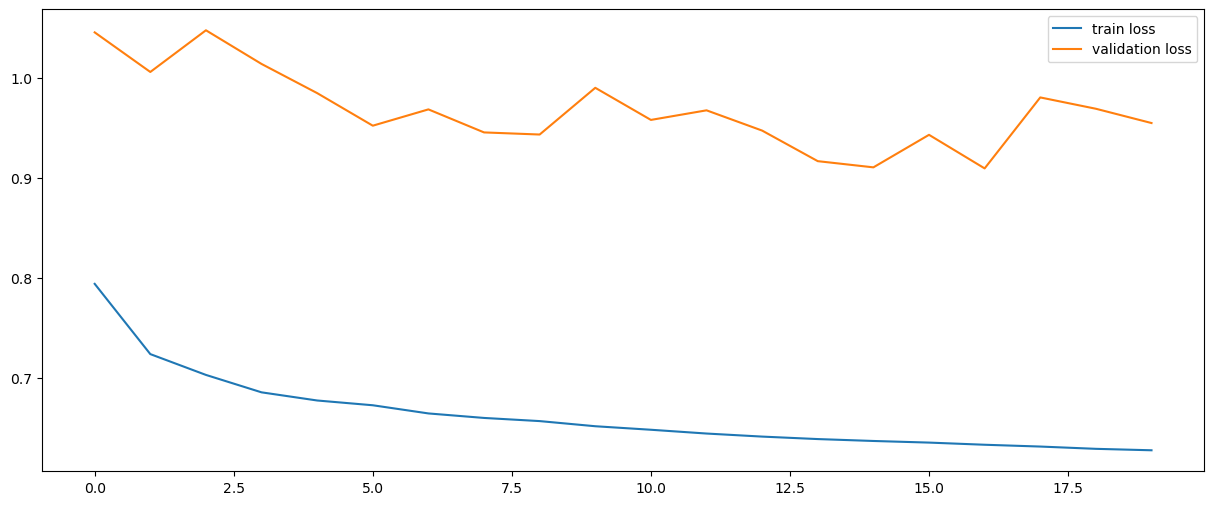

In [33]:
plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

In [34]:

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.6064


In [35]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6063717941910476
              precision    recall  f1-score   support

           0     0.1540    0.3529    0.2145     22858
           1     0.8749    0.6483    0.7447    240272
           2     0.1434    0.3857    0.2091     19365

    accuracy                         0.6064    282495
   macro avg     0.3908    0.4623    0.3894    282495
weighted avg     0.7664    0.6064    0.6651    282495



In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
model.load_state_dict(torch.load('/Users/jandh/Desktop/Old Desktop/od/1 quater/Project Lab/fast-alphas/best_val_roLOB.pt', map_location=mps_device))

/var/folders/vf/gw1t6f4j3mv84kp8kpw4j_bw0000gn/T/ipykernel_45960/1618523788.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/jand

<All keys matched successfully>

# Training with adjusted class frequncy weighted loss function

In [22]:
n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in test_loader:
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.6471


In [25]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.6471477371280908
              precision    recall  f1-score   support

           0     0.1791    0.3533    0.2377     22858
           1     0.8760    0.6971    0.7764    240272
           2     0.1566    0.3736    0.2207     19365

    accuracy                         0.6471    282495
   macro avg     0.4039    0.4747    0.4116    282495
weighted avg     0.7703    0.6471    0.6947    282495



In [26]:
confusion_matrix(all_targets,all_predictions)

array([[  8076,  12780,   2002],
       [ 35804, 167505,  36963],
       [  1206,  10924,   7235]])

# LOB data Hong_Song

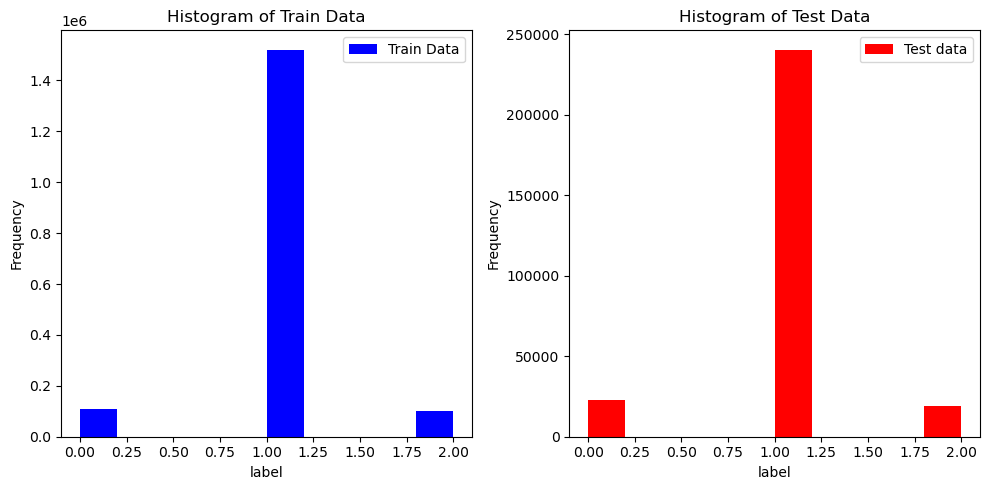

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first histogram
axs[0].hist(dataset_train.y, color='blue', label='Train Data')
axs[0].set_xlabel('label')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Train Data')
axs[0].legend()

# Plot the second histogram
axs[1].hist(dataset_test.y, color='red', label='Test data')
axs[1].set_xlabel('label')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Test Data')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Train data Stats

In [27]:
n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in train_loader:
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.8759


In [28]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.8759320147910366
              precision    recall  f1-score   support

           0     0.5223    0.9708    0.6792    110877
           1     0.9967    0.8620    0.9245   1520881
           2     0.4690    0.9812    0.6346    100913

    accuracy                         0.8759   1732671
   macro avg     0.6626    0.9380    0.7461   1732671
weighted avg     0.9356    0.8759    0.8919   1732671



In [29]:
confusion_matrix(all_targets,all_predictions)

array([[ 107639,    2916,     322],
       [  98040, 1311051,  111790],
       [    421,    1480,   99012]])

In [31]:
n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

for inputs, targets in val_loader:
    # Move to GPU
    model.eval()
    inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

    all_targets.append(targets.cpu().numpy())
    all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")

all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)   

Test acc: 0.6477


In [32]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))

accuracy_score: 0.647665402891751
              precision    recall  f1-score   support

           0     0.2016    0.4478    0.2780     41611
           1     0.8133    0.7386    0.7741    344789
           2     0.2620    0.1544    0.1943     46694

    accuracy                         0.6477    433094
   macro avg     0.4256    0.4469    0.4155    433094
weighted avg     0.6951    0.6477    0.6639    433094

